Demonstrate the following interpolation methods
* Bilinear interpolation
* Inverse distance weighting
* Ordinary kriging
* Radial basis function regression

Annual mean PM2.5 concentrations are used as an example variable.

In [1]:
# Packages that we need
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import proplot

In [2]:
# Read PM2.5 and AQI data
point_data = pd.read_csv( 'EPA_AQS_PM25_Florida_2022.csv' )

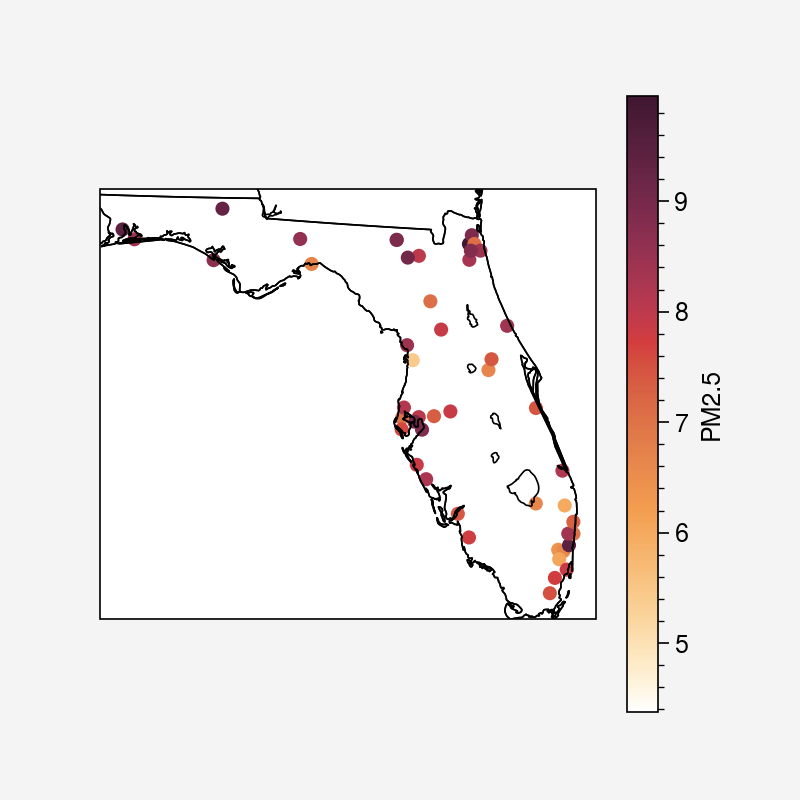

In [3]:
# Display the point data on a map
projFL = ccrs.TransverseMercator( central_longitude=( point_data['Longitude'].min() + point_data['Longitude'].max() ) / 2,
                                  central_latitude=( point_data['Latitude'].min() + point_data['Latitude'].max() ) / 2 )

ax = plt.subplot(111, projection=projFL)
point_data.plot.scatter( 'Longitude', 'Latitude', c='PM2.5', 
                  ax=ax,
                  transform=ccrs.PlateCarree() )
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')

In [4]:
# Degrees of Latitude and Longitude are not equal distance increments, 
# Convert to a regional projection using meters in x and y directions
result = projFL.transform_points( ccrs.PlateCarree(), 
                                 point_data['Longitude'], 
                                 point_data['Latitude'] )
point_data['x'] = result[:,0]
point_data['y'] = result[:,1]

In [21]:
# Create a grid with regular spacing in x and y
# The point data will be interpolated to this new grid

# Extend the grid this distance outside the data points, m
buffer = 100e3

xnew = np.linspace( point_data['x'].min()-buffer,
                    point_data['x'].max()+buffer,
                    200 )
ynew = np.linspace( point_data['y'].min()-buffer,
                    point_data['y'].max()+buffer, 
                    200 )

# Broadcast these together
xnew2d, ynew2d = np.meshgrid( xnew, ynew )

# Save the new grid in a dataframe with columns
new_grid = pd.DataFrame( {'x':xnew2d.ravel(), 
                          'y':ynew2d.ravel()} )


# Linear Interpolation

In [22]:
from scipy.interpolate import griddata

# Note that griddata has other interpolation methods available as well
predict_bilinear = griddata( point_data[['x','y']], 
                            point_data['PM2.5'], 
                            new_grid, 
                            method='linear' ).\
                    reshape( xnew2d.shape )

# Radial basis function

In [23]:
from scipy.interpolate import RBFInterpolator

predict_RBF = RBFInterpolator( point_data[['x','y']], 
                           point_data['PM2.5'],
                           kernel='linear' )( new_grid ).\
                    reshape( xnew2d.shape )

# Inverse distance weighting

In KNeighborsRegressor, specify the number of neighboring points that will be combined.

In RadiusNeighborsRegressor, all points within the specifed radius will be combined.

In [24]:
# Inverse distance weighting
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

model = KNeighborsRegressor( n_neighbors=40,
                                weights='distance').fit( point_data[['x','y']],
                                                            point_data['PM2.5'] )
model = RadiusNeighborsRegressor( radius=100e3, #Distance in meters
                                  weights='distance').fit( point_data[['x','y']],
                                                            point_data['PM2.5'] )
predict_IDW = model.predict( new_grid ).\
                    reshape( xnew2d.shape )


/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/neighbors/_regression.py:500: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


# Ordinary Kriging

Kriging is a geostatistical method and a special case of Gaussian Process Regression. Unlike the other methods here, kriging provides uncertainty estimate along with values. 

In [80]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# Covariance kernel
# Units for ConstantKernel and WhiteKernel are same as data (ug/m3)
# Units for RBF are distance (m)
# WhiteKernel specifies that measurement values have some uncertainty, specified as stddev. 
# In this example, RBF says that length scale for correlation between measurements is 5-500km, with a first guess of 50km
# WhiteKernel says error in an idividual measurement (annual average) is .003-0.5 µg/m3, with a first guess of 0.01
# ConstantKernel says that points at any distance from each other are expected to have additional covariance
kernel = ConstantKernel(1,(1e-8,100)) + RBF(50e3, (5e3,5e5)) + WhiteKernel(0.01, (1e-3,0.5))
# kernel = RBF(50e3, (5e3,5e5)) + WhiteKernel(0.01, (1e-3,0.5))

gp = GaussianProcessRegressor(kernel=kernel,
                              normalize_y=True,
                              n_restarts_optimizer=20)
gp.fit( point_data[['x','y']],
        point_data['PM2.5'] )

predict_krig, predict_krig_std = gp.predict( new_grid,
                                            return_std=True )

# Reshape the results
predict_krig = predict_krig.\
                    reshape( xnew2d.shape )
predict_krig_std = predict_krig_std.\
                    reshape( xnew2d.shape )

# Print the optimized kernel; Check this for reasonableness 
# The ConstantKernel is extremely small, so could be omitted
gp.kernel_

/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 5000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.0001**2 + RBF(length_scale=5e+03) + WhiteKernel(noise_level=0.186)

# Display results

/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/cartopy/mpl/geoaxe

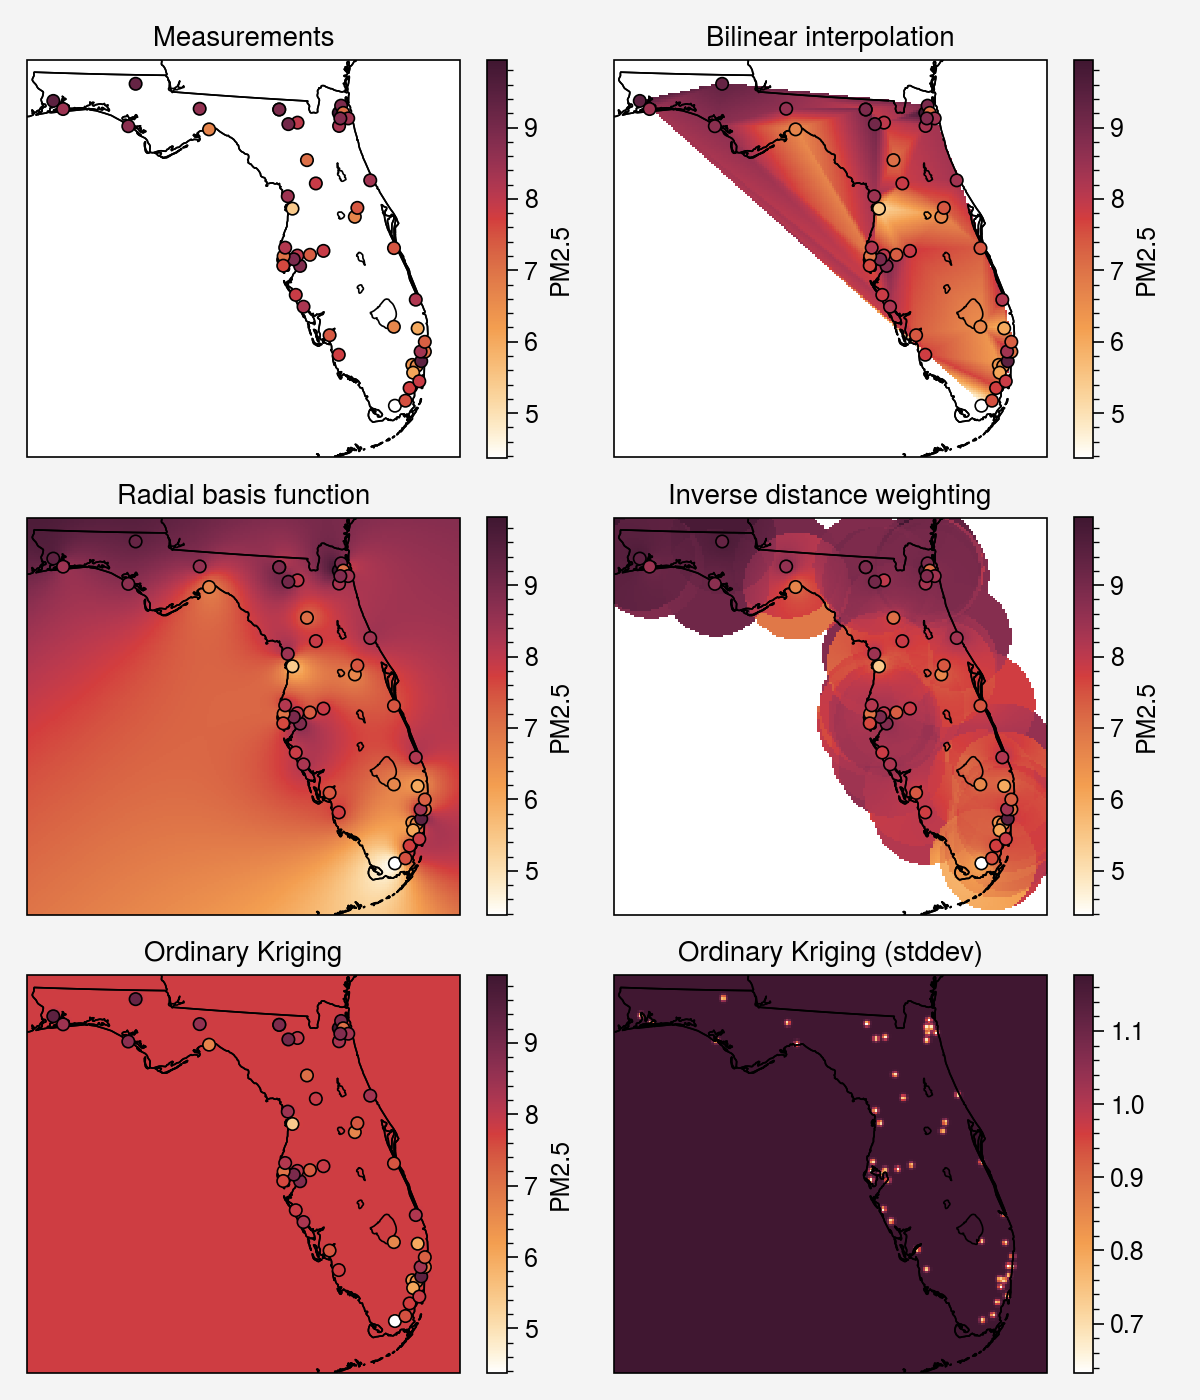

In [81]:
# Plot all of the interpolation methods
fig, axs = plt.subplots( 3, 2, 
                        figsize=(6,7),
                        subplot_kw={'projection':projFL})

# Display data points, coastlines on all panels
for ax in axs.flat:
    
    # Skip data points on last panel
    if ax is not axs.flat[-1]:
        point_data.plot.scatter( 'Longitude', 'Latitude', c='PM2.5',
                            edgecolor='black', 
                            ax=ax,
                            transform=ccrs.PlateCarree(),
                            zorder=10 )
    ax.coastlines()
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')

    ax.set_extent([-87.5,-79.5,24.5,31.2],ccrs.PlateCarree())

axs[0,0].set_title('Measurements')

axs[0,1].pcolormesh( xnew2d, ynew2d, predict_bilinear, transform=projFL )
axs[0,1].set_title('Bilinear interpolation')

axs[1,0].pcolormesh( xnew2d, ynew2d, predict_RBF, transform=projFL )
axs[1,0].set_title('Radial basis function')

axs[1,1].pcolormesh( xnew2d, ynew2d, predict_IDW, transform=projFL )
axs[1,1].set_title('Inverse distance weighting')

axs[2,0].pcolormesh( xnew2d, ynew2d, predict_krig, transform=projFL )
axs[2,0].set_title('Ordinary Kriging')

p=axs[2,1].pcolormesh( xnew2d, ynew2d, predict_krig_std, transform=projFL )
axs[2,1].set_title('Ordinary Kriging (stddev)')
fig.colorbar(p)

plt.tight_layout()